In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import timm
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import sys
import time
import json
import shutil

# preparing data and dataset

* Read in labels and print the chart 'overall.csv'.

In [2]:
PATH_DATA = '../data'

data_chart = pd.read_csv(os.path.join(PATH_DATA, 'data.csv'))
categories = os.listdir(os.path.join(PATH_DATA, 'classified'))
img_cls = {cate:[img for img in os.listdir(os.path.join(PATH_DATA, 'classified', cate))] for cate in categories}

for i in range(1, 4):  # read in labels
    col = f'img{i}_cls'
    data_chart.insert(data_chart.shape[1], col, 'None')
    img_cls_list = data_chart[col]
    for j, img in enumerate(data_chart[f'images_{i}']):
        for k, v in img_cls.items():
            if img in v:
                data_chart.loc[j, col] = k
                break

data_chart.to_csv(os.path.join(PATH_DATA, 'overall.csv'))

data_chart

,hotel_names,distances,grades,prices,sleeps,reviewCounts,room_types,viewed_times,sizes,brs,bas,images_1,images_2,images_3,img1_cls,img2_cls,img3_cls
0,Stunning Studio | Balcony | Gold Coast by Lyric,1.5 mi to Chicago center,None,129,2,1,Apartment,20,540,1,1,c60e1942-aa77-4554-8863-a7e8d0355f34.c6.jpg,e806b1e2-9f14-4575-be16-8a9f64e2dd0a.c6.jpg,b0dfa1a0-aa52-473e-bc62-ee20abba6271.c6.jpg,Type of Place,Type of Place,Room Amenities
1,Hidden Gem - Gold Coast of Chicago,1.7 mi to Chicago center,None,139,6,2,House,160,1,2,2,c8cf30dc-d6a5-47c3-9f52-73ee5f05e41f.c6.jpg,9c0d963a-e65d-47c4-bf14-85743357f619.c6.jpg,56bd4284-12da-45a0-a3fe-50f5da387bfe.c6.jpg,Room Amenities,Type of Place,Room Amenities
2,Bright 1BR in Near North by Sonder,1.7 mi to Chicago center,None,105,2,1,Apartment,36,463,1,1,24caf3ff-6f20-4991-a1fb-97ec9f223e67.c6.jpg,841029e8-6b03-4f71-b94b-7905013a0779.c6.jpg,d1278589-601a-4e8d-97a5-0a25cdb5113f.c6.jpg,Room Amenities,Room Amenities,Room Amenities
3,Lux Studio | WiFi + Fitness | Gold Coast by Lyric,1.5 mi to Chicago center,5,126,4,6,Apartment,39,700,1,1,6383d6b6-043b-4fa0-bbef-3386b7bcfed3.c6.jpg,64e5d231-0d60-460d-a9f4-d4b58ae054c5.c6.jpg,f9201f5c-6c6b-4df3-a41e-1a575e1e0ace.c6.jpg,Room Amenities,Room Amenities,Type of Place
4,Charming One Bed in the heart of Lincoln Park,2.8 mi to Chicago center,4.8,117,2,51,Apartment,51,None,1,1,1ba86d44-e25d-46e7-9c84-81e5bf2a3107.c6.jpg,9c321394-256d-4320-964d-a612c73e0ca6.c6.jpg,3ccf4fb9-bb2b-46dd-afad-ed8780df4c5f.c6.jpg,Facade,Room Amenities,Room Amenities
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,Convenient to Public Transit and SAFE Neighbor...,6.5 mi to Chicago center,4.5,476,13,38,House,9,2600,5,3,a0b3a50c-1fc3-40d8-a2ae-760b7cc9c97f.c6.jpg,178c7dad-9066-4391-ae54-03c03610a54a.c6.jpg,7e810ac2-c82b-468d-82fb-2554e100b589.c6.jpg,Room Amenities,Room Amenities,Type of Place
1015,Modern luxury in Chicago's Lakeview,4.5 mi to Chicago center,None,999,10,3,House,None,4800,6,4,24338574-7892-4f34-a15d-96f30423d4b9.c6.jpg,36f5fe80-a7f9-45d8-a9df-94277be37577.c6.jpg,e66b047f-1aae-494f-bf07-075c45f36566.c6.jpg,Room Amenities,Facade,Room Amenities
1016,Modern luxury in Chicago's Lakeview,4.5 mi to Chicago center,None,999,6,0,House,None,4800,6,5,070b27df-cfe8-414d-a1c3-ed821eacda1c.c6.jpg,ba8461f1-a4db-4aa2-8d74-bc9930322cd4.c6.jpg,0c778945-caf8-4390-91ae-5be371b6cc08.c6.jpg,Room Amenities,Facade,Room Amenities
1017,Beautiful Historical Pullman Rowhouse located ...,13.1 mi to Chicago center,None,125,5,2,Townhome,None,1250,3,1,3677cb31-2cd4-4aed-9931-93640d36c2d2.c6.jpg,5d44c0e9-b040-4db1-85ba-af24731d7de0.c6.jpg,59bedcd4-bee1-44ff-a5f0-0d3a6ab8b364.c6.jpg,Room Amenities,Room Amenities,Room Amenities


* Splite 'overall.csv' into 3 splits randomly according to the paper, 6:2:2, and copy original images into corresponding dir.

In [3]:
random_chart = data_chart.copy()
random_chart = random_chart.sample(frac=1)

keys = ['train', 'val', 'test']
vals = np.array_split(random_chart, [int(0.6*random_chart.shape[0]), int(0.8*random_chart.shape[0])])

charts = dict(zip(keys, vals))

for type, chart in charts.items():
    chart.reset_index(inplace=True)
    chart.to_csv(os.path.join(PATH_DATA, f'{type}.csv'))

    dir = os.path.join(PATH_DATA, type)
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)
    for cls in categories:
        os.mkdir(os.path.join(dir, cls))

    for i in range(1, 4):
        img_list = f'images_{i}'
        for j, file in enumerate(chart[img_list]):
            if file is None:
                continue
            cls = str(chart[f'img{i}_cls'][j])
            if cls == 'None':
                continue
            image = cv2.imread(os.path.join(PATH_DATA, 'images', str(file)))
            cv2.imwrite(os.path.join(dir, (chart.loc[j, f'img{i}_cls']), str(file)), image)

In [4]:
def data_hotel_cls(batch_size, num_workers=0, data_transform=None):
    """
    Prepare train_loader and val_loader for training.

    :param batch_size: 8~64 depends on your GPU physical memory.
    :param num_workers: Should be zero on Windows platform.
    :param data_transform: Specified your data augmentation.
    :return: train_loader, val_loader
    """
    if data_transform is None:
        data_transform = {
            "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            "val": transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            "test": transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor()]),
        }

    # image_path = os.path.join(PATH_DATA, 'images')
    train_dataset = datasets.ImageFolder(root=os.path.join(PATH_DATA, 'train'),
                                         transform=data_transform['train'])
    val_dataset = datasets.ImageFolder(root=os.path.join(PATH_DATA, 'val'),
                                       transform=data_transform['val'])
    test_dataset = datasets.ImageFolder(root=os.path.join(PATH_DATA, 'test'),
                                       transform=data_transform['test'])
    cls_list = train_dataset.class_to_idx
    cls_dict = dict((val, key) for key, val in cls_list.items())
    json_str = json.dumps(cls_dict, indent=4)
    with open(os.path.join(PATH_DATA, 'cls.json'), 'w') as json_file:
        json_file.write(json_str)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                             shuffle=False, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

# train script

In [7]:
def train(net, train_loader, val_loader, loss_function, optimizer, scheduler, device, epoch_num, save_dir=None):
    timseq = [time.time()]

    train_num = len(train_loader.dataset)
    val_num = len(val_loader.dataset)
    val_data_iter = iter(val_loader)
    val_image, val_label = val_data_iter.__next__()  # not the `.next()` but the `.__next__()`

    train_loss, val_accuracy = [], []
    best_acc = 0.0
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        # -------------------------------------------- train --------------------------------------------------
        net.train()  # set as train mode, keep the dropout
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)  # 进度条
        for step, data in enumerate(train_bar):
            inputs, labels = data  # get the inputs; data is a list of [inputs, labels]
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = net(inputs.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()  # forward + backward + optimize
            optimizer.step()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epoch_num, loss)

            if step % 500 == 499:  # print every 500 mini-batches
                with torch.no_grad():
                    outputs = net(val_image.to(device))  # [batch, 10]
                    predict_y = torch.max(outputs, dim=1)[1]
                    accuracy = torch.eq(predict_y, val_label.to(device)).sum().item() / val_label.size(0)

                    print('[epoch: %d, step: %5d] last_500_loss: %.3f  test_accuracy: %.3f'
                          % (epoch + 1, step + 1, running_loss / 500, accuracy))

            running_loss += loss.item()

        train_loss.append(running_loss / train_num)

        if scheduler is not None:
            scheduler.step()

        # -------------------------------------------- validate ----------------------------------------------
        net.eval()  # call back dropout
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(val_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))  # net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]  # 提出最大概率
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()  # val_labels.to(device)).sum().item()
                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1, epoch_num)

        # Record processing
        val_accuracy.append(acc / val_num)
        timseq.append(time.time())
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f cost time: %.2f' %
              (epoch + 1, train_loss[-1], val_accuracy[-1], timseq[-1] - timseq[-2]))

        # save the best model
        if val_accuracy[-1] > best_acc:
            best_acc = val_accuracy[-1]
            torch.save(net.state_dict(), os.path.join(save_dir, 'weight', "best.pth"))

    # ------------------------------------ save result ----------------------------------------------------
    # save weight
    torch.save(net.state_dict(), os.path.join(save_dir, 'weight', 'last.pth'))  # weight

    # save matplot pics
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), tight_layout=True)
    axes[0].plot(train_loss, label="train loss", ls='-', color='black')
    axes[1].plot(val_accuracy, label="val acc", ls='-', color='red')
    fig.savefig(os.path.join(save_dir, 'result.jpg'))  # pic
    plt.show()

    # save csv chart
    df = pd.DataFrame(np.array([np.arange(0, epoch_num), train_loss, val_accuracy]).T,
                      index=None, columns=['epoch', 'train_loss', 'val_accuracy'])
    df.to_csv(os.path.join(save_dir, 'result.csv'), index=False)  # csv

    # print optimizer
    print("Hyper-parameter:")
    print("optim:", optimizer, "\nepoch_num:", epoch_num)
    print("run time: %.2f s" % (timseq[-1] - timseq[0]))
    print('Finished Training')


def generate_savedir(save_name) -> str:
    # Generate save directory with 'YearMonthDate-Hour-Minute-Second' format.
    # the save file name doesn't allow the sign ':'
    str_now = time.strftime("%Y%m%d-%H-%M-%S")
    if save_name is None:
        save_name = str_now
    else:
        save_name = str_now + '-' + save_name
    save_dir = os.path.join('../output', save_name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    os.makedirs(os.path.join(save_dir, 'weight'))

    return save_dir

valid epoch[1/2]: 100%|██████████| 611/611 [00:06<00:00, 96.15it/s] 
[epoch 1] train_loss: 0.032  val_accuracy: 0.704 cost time: 23.06
valid epoch[2/2]: 100%|██████████| 611/611 [00:06<00:00, 94.09it/s]
[epoch 2] train_loss: 0.029  val_accuracy: 0.669 cost time: 23.63


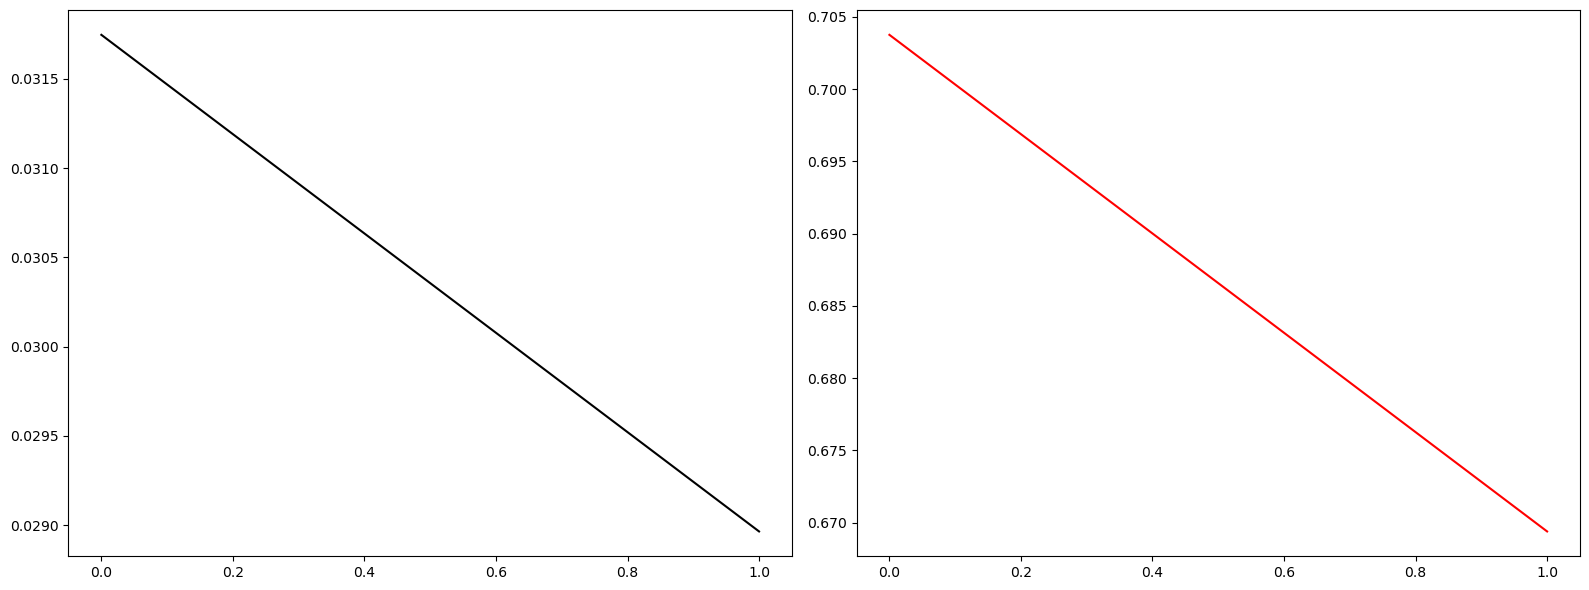

Hyper-parameter:
optim: SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
) 
epoch_num: 2
run time: 46.70 s
Finished Training


In [8]:
# hyper-param
batch_size = 32
num_epoch = 2
learning_rate = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader, val_loader, test_loader = data_hotel_cls(batch_size=batch_size)

# Xception
model = timm.create_model('xception', pretrained=False)  # pretrained=True for faster training
model.fc = torch.nn.Linear(model.fc.in_features, len(categories))
model.to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Stochastic Gradient Descent

save_dir = generate_savedir('Xception_hotel_CLS')
train(model, train_loader, val_loader, loss_func, optimizer, None, device, num_epoch, save_dir)

In [15]:
def predict(device, model, weight_path, test_chart):
    data_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    predict_chart = test_chart.copy()

    model.to(device)
    model.load_state_dict(torch.load(weight_path))
    model.eval()

    json_path = os.path.join(PATH_DATA, 'cls.json')
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)
    with open(json_path, 'r') as f:
        class_indict = json.load(f)

    with torch.no_grad():
        for i in range(1, 4):
            img_list = f'images_{i}'
            col = f'predict_img{i}'
            predict_chart.insert(predict_chart.shape[1], col, 'None')
            for j, file in enumerate(chart[img_list]):
                if file is None:
                    continue
                image = Image.open(os.path.join(PATH_DATA, 'images', str(file)))
                image = data_transform(image)
                image = torch.unsqueeze(image, dim=0)

                output = torch.squeeze(model(image.to(device))).cpu()
                predict = torch.softmax(output, dim=0)
                predict_cls = torch.argmax(predict).numpy()

                predict_chart.loc[j, col] = class_indict[str(predict_cls)]

    predict_chart.to_csv(os.path.join(PATH_DATA, 'predict.csv'))

In [16]:
test_chart = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'))
predict(device, model, "../output/20230603-16-35-48-Xception_hotel_CLS/weight/last.pth",
        test_chart)